In [1]:
print('Start import')
import socket 
import strax
import straxen
import numpy as np
import datetime
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import datetime
import pandas as pd
print(
f'''Working on {socket.getfqdn()} with the following versions 
and installation paths:
strax
\tv{strax.__version__}\t{str(strax.__path__[0])}
straxen
\tv{straxen.__version__}\t{str(straxen.__path__[0])}
''')
from multihist import Hist1d, Histdd
import time
import itertools
import os
from scipy.optimize import curve_fit

Start import
Working on midway2-0465.rcc.local with the following versions 
and installation paths:
strax
	v0.15.1	/dali/lgrandi/strax/strax/strax
straxen
	v0.18.3	/dali/lgrandi/strax/straxen/straxen



In [2]:
st = straxen.contexts.xenon1t_dali()

In [3]:
run_Rn = '170314_0419'
run_Kr = '170206_1355'
run_Ar = '181027_0841'

In [98]:
def plot_area_width_aft(run_id, low = 0, high = 7, low2 = 0, high2 = 1, binning = 500,title='Kr-83m run'):
    events = st.get_array(run_id,'event_info')
    ph_s1 = Histdd(events['s1_area'], events['s1_range_50p_area'],
                    bins=(np.logspace(low, high, binning), np.logspace(1, 6, binning)))
    ph_s2 = Histdd(events['s2_area'], events['s2_range_50p_area'],
                    bins=(np.logspace(low, high, binning), np.logspace(1, 6, binning)))
    phcs1 = Histdd(events['s1_area'], events['s1_area_fraction_top'],
                    bins=(np.logspace(low, high, binning), np.linspace(0, 1, binning)))
    phcs2 = Histdd(events['s2_area'], events['s2_area_fraction_top'],
                    bins=(np.logspace(low, high, binning), np.linspace(0, 1, binning)))
    plt.figure(figsize=(12,6))
    ph_s1.plot(log_scale=True, cblabel='S1 events',cmap='plasma')
    ph_s2.plot(log_scale=True, cblabel='S2 events')
    plt.xlabel("peak area (PE)", ha='right', x=1)
    plt.ylabel("peak width 50% (ns)", ha='right', y=1)
    plt.title(f'{title}')
    plt.xscale('log')
    plt.yscale('log')
    plt.figure(figsize=(12,6))
    phcs1.plot(log_scale=True, cblabel='S1 events',cmap='plasma')
    phcs2.plot(log_scale=True, cblabel='S2 events')
    plt.xlabel("peak area (PE)", ha='right', x=1)
    plt.ylabel("area fraction top", ha='right', y=1)
    plt.title(f'{title}')
    plt.xscale('log')

In [99]:
def plot_drift_time(run, bins = 300,title='Kr-83m run'):
    events = st.get_array(run,'event_info')
    phd = Histdd(events['drift_time']/1000, events['s2_area'],
                bins=(np.linspace(0, 800, bins), np.linspace(0, 35000, bins)))
    phw = Histdd(events['drift_time']/1000, events['s2_range_50p_area'],
                bins=(np.linspace(0, 800, bins), np.logspace(1, 4, bins)))
    plt.figure(figsize=(12,6))
    phd.plot(log_scale=True, cblabel='events')
    plt.xlabel("drift time ($\mu$s)", ha='right', x=1,fontsize=12)
    plt.ylabel("S2 area (PE)", ha='right', y=1,fontsize=12)
    plt.title(f'{title}',fontsize=14)
    #plt.yscale('log')
    
    plt.figure(figsize=(12,6))
    phw.plot(log_scale=True, cblabel='events')
    plt.xlabel("drift time ($\mu$s)", ha='right', x=1,fontsize=12)
    plt.ylabel("S2 width 50% (ns)", ha='right', y=1,fontsize=12)
    plt.title(f'{title}',fontsize=14)
    plt.yscale('log')

Loading event_info: |          | 0.00 % [00:00<?]

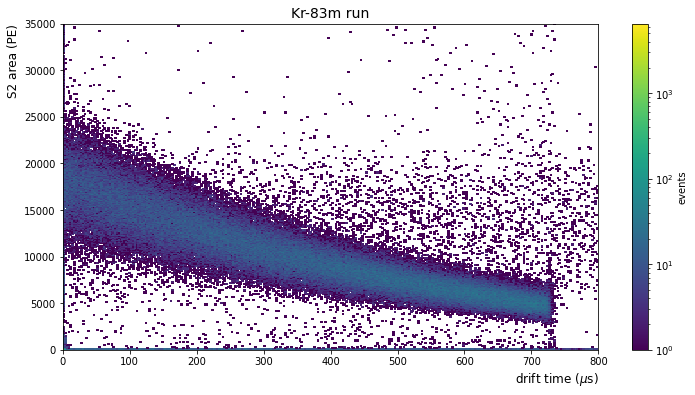

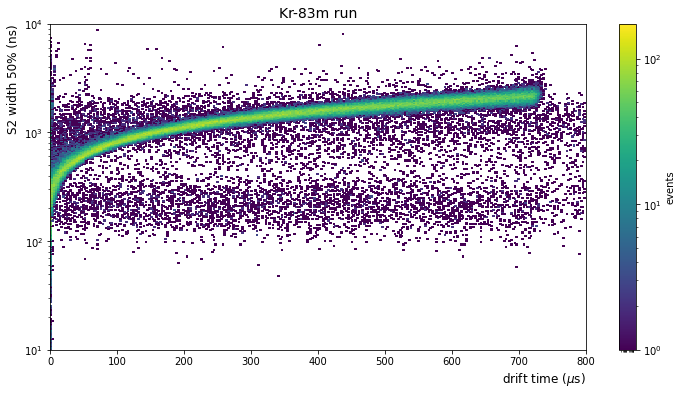

In [100]:
plot_drift_time(run_Kr)

In [101]:
def plot_drift_time_aft(run, low = 0, high = 800, low2 = 0, high2 = 1, binning = 500,title='Kr-83m run'):
    events = st.get_array(run,'event_info')
    pha1 = Histdd(events['drift_time']/1000, events['s1_area_fraction_top'],
                bins=(np.linspace(low, high, binning), np.linspace(low2, high2, binning)))
    pha2 = Histdd(events['drift_time']/1000, events['s2_area_fraction_top'],
                bins=(np.linspace(low, high, binning), np.linspace(low2, high2, binning)))
    plt.figure(figsize=(12,6))
    pha1.plot(log_scale=True, cblabel='events')
    plt.xlabel("drift time ($\mu$s)", ha='right', x=1,fontsize=12)
    plt.ylabel("S1 area fraction top", ha='right', y=1,fontsize=12)
    plt.title(f'{title}',fontsize=14)
    
    #plt.figure(figsize=(12,6))
    #pha2.plot(log_scale=True, cblabel='events')
    #plt.xlabel("drift time ($\mu$s)", ha='right', x=1,fontsize=12)
    #plt.ylabel("S2 area fraction top", ha='right', y=1,fontsize=12)
    #plt.title(f'run {run_id}',fontsize=14)

Loading event_info: |          | 0.00 % [00:00<?]

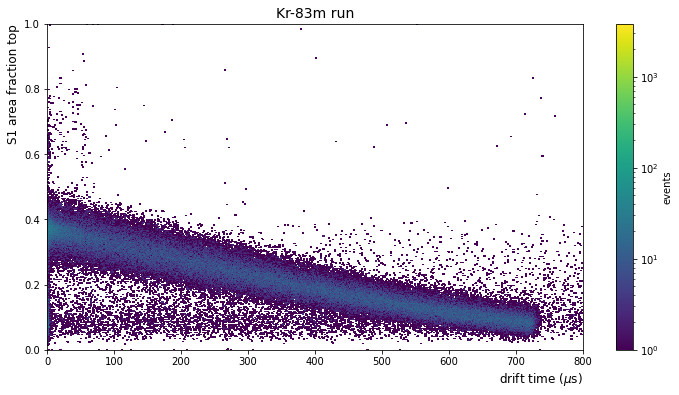

In [102]:
plot_drift_time_aft(run_Kr)

In [103]:
def expo(t, tau, A):
    return A * np.exp(-t/tau)

def electron_lifetime(run, bins=100, width_cut=4000, area_cut = (1,25000),
                      dt_cut = 700, title='Kr-83m run'):
    events = st.get_array(run,'event_info')
    ev_sel = events#[(events['s2_range_50p_area'] < width_cut) &
                   # (events['s1_area'] > area_cut[0]) &
                   # (events['s1_area'] < area_cut[1])]
    
    plt.figure(figsize=(12,6))
    t = np.linspace(10, dt_cut,bins)
    #mh = Histdd(ev_sel['drift_time']/1000, (ev_sel['s2_area']*(1 - ev_sel['s2_area_fraction_top'])),
    #                    bins=(t, np.linspace(1, 15000, bins)))
    mh = Histdd(ev_sel['drift_time']/1000, (ev_sel['s2_area']),
                        bins=(t, np.linspace(area_cut[0], area_cut[1], bins)))
    mean_s2 = mh.average(axis=1)
    mean_s2 = np.array(mean_s2)
    mh.plot(log_scale=True, cblabel='events')
    plt.plot(t[:len(mean_s2)],mean_s2,color='r', label='mean per drift time slice')
    plt.xlabel("drift time ($\mu$s)", ha='right', x=1,fontsize=12)
    plt.ylabel("S2 area (PE)", ha='right', y=1,fontsize=12)
    plt.title(f'{title}',fontsize=14)
    #plt.yscale('log')
    plt.legend(fontsize=14)

    plt.figure(figsize=(12,6))
    plt.plot(t[1:],mean_s2,label='mean values')
    plt.xlabel("drift time ($\mu$s)", ha='right', x=1,fontsize=12)
    plt.ylabel("S2 bottom (PE)", ha='right', y=1,fontsize=12)
    guess = [400, 7000]
    popt, pcov = curve_fit(expo,t[:len(mean_s2)], mean_s2, p0=guess)
    perr = np.sqrt(np.diag(pcov))
    #plt.plot(t, expo(t, *guess), label='guess')
    plt.plot(t, expo(t, *popt), label=f'fit: ${popt[0]:.1f} \pm {perr[1]:.1f}~\mu$s lifetime')
    plt.title(f'{title}',fontsize=14)
    plt.legend(fontsize=14)

Loading event_info: |          | 0.00 % [00:00<?]

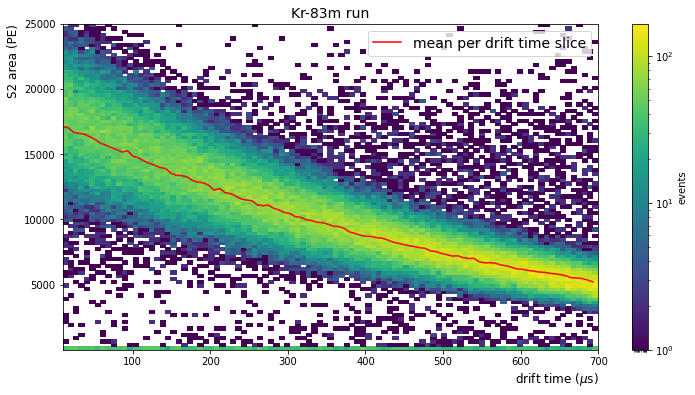

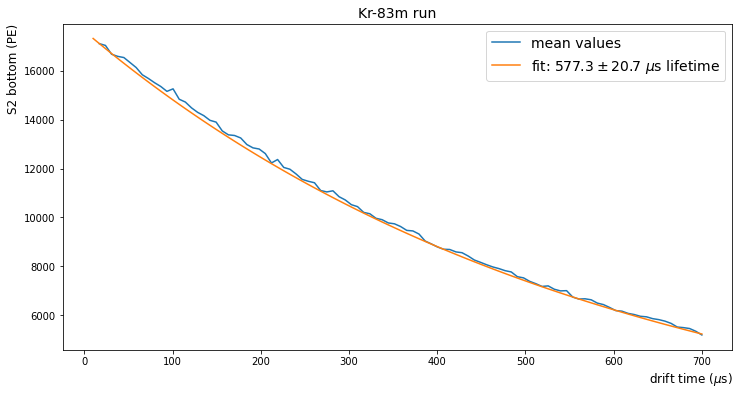

In [104]:
electron_lifetime(run_Kr)

In [105]:
def calculate_electron_lifetime(run,title='Kr-83m run',area_cut = (1,25000)):
    plot_area_width_aft(run,title=title)
    plot_drift_time(run,title=title)
    plot_drift_time_aft(run,title=title)
    electron_lifetime(run,title=title,area_cut = area_cut)

Loading event_info: |          | 0.00 % [00:00<?]

Loading event_info: |          | 0.00 % [00:00<?]

Loading event_info: |          | 0.00 % [00:00<?]

Loading event_info: |          | 0.00 % [00:00<?]

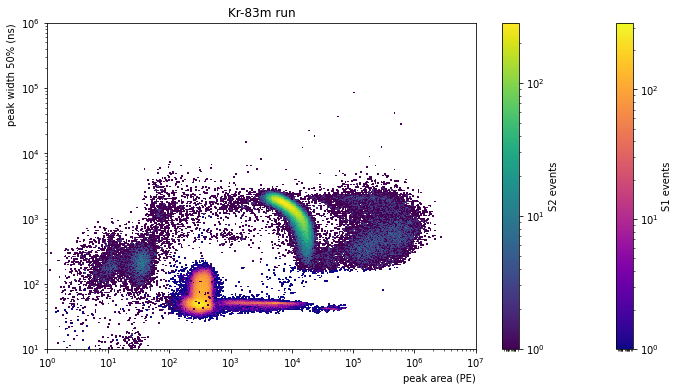

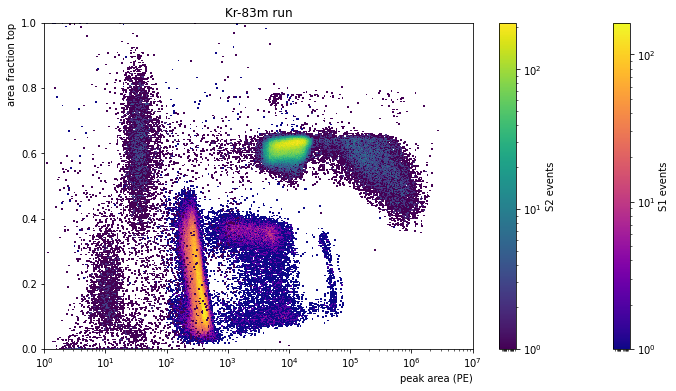

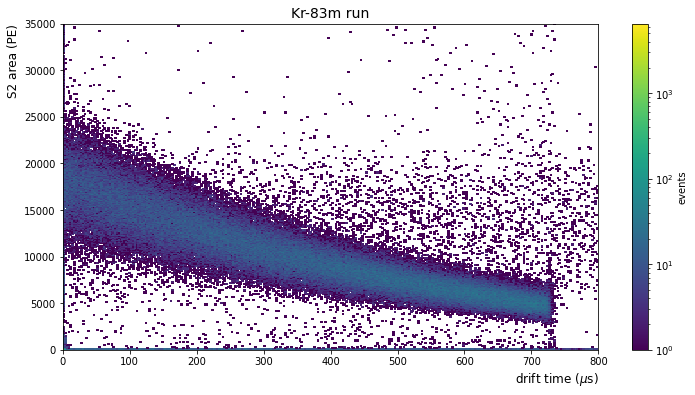

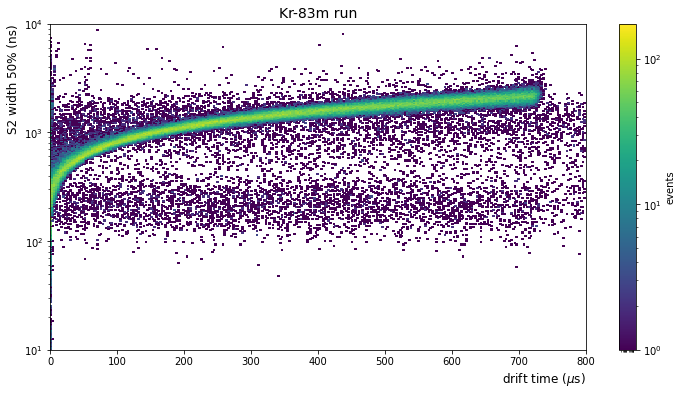

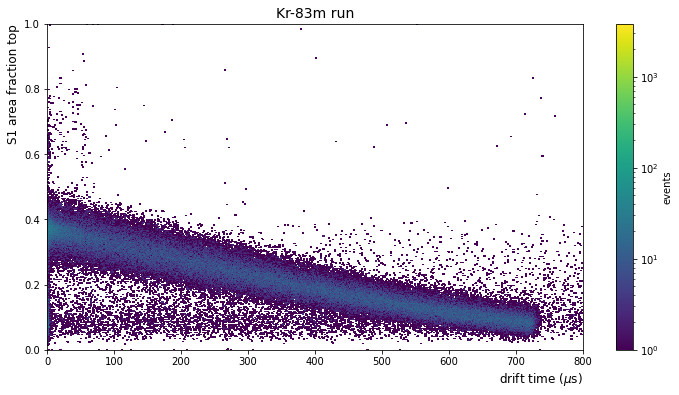

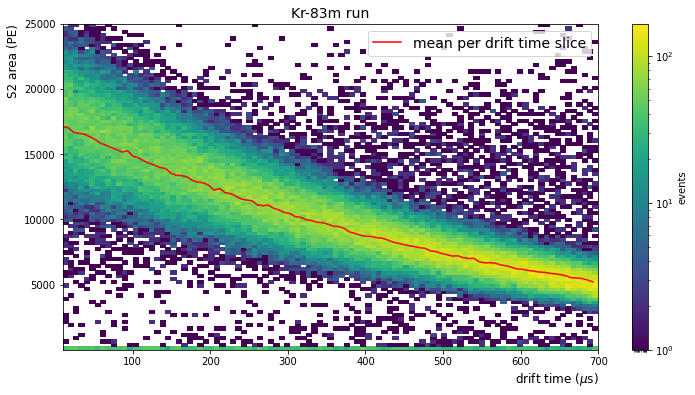

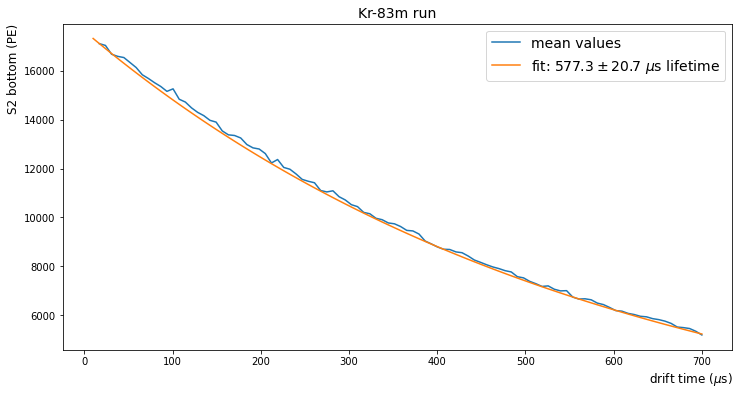

In [106]:
calculate_electron_lifetime(run_Kr,title='Kr-83m run',area_cut=(1,25000))

Loading event_info: |          | 0.00 % [00:00<?]

Loading event_info: |          | 0.00 % [00:00<?]

Loading event_info: |          | 0.00 % [00:00<?]

Loading event_info: |          | 0.00 % [00:00<?]

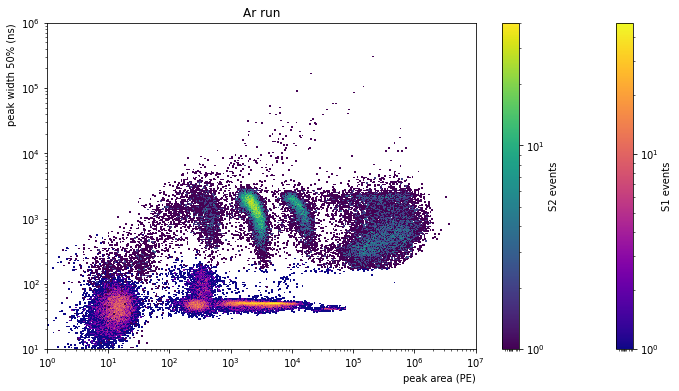

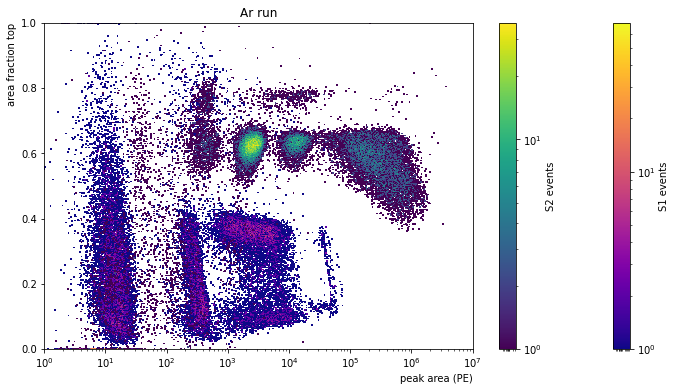

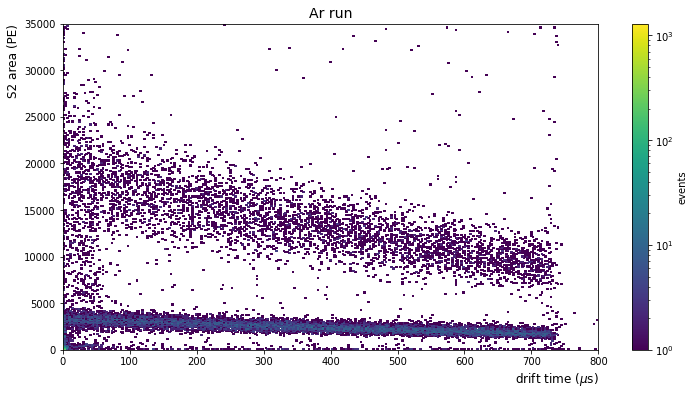

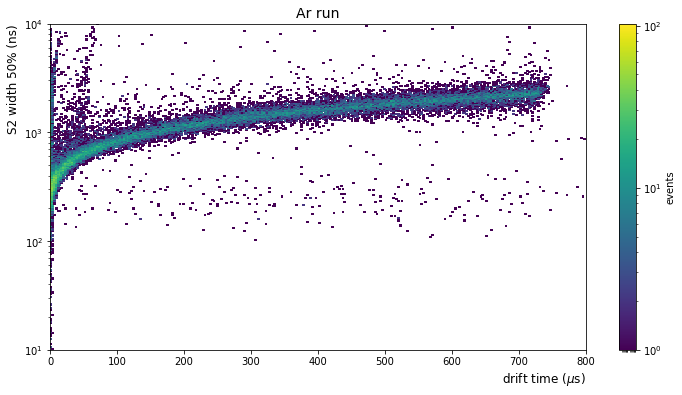

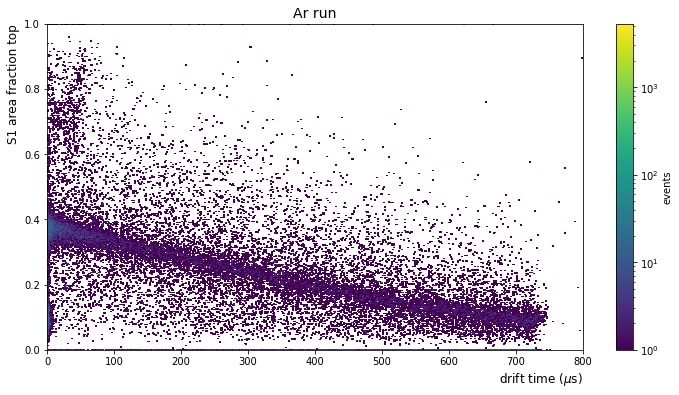

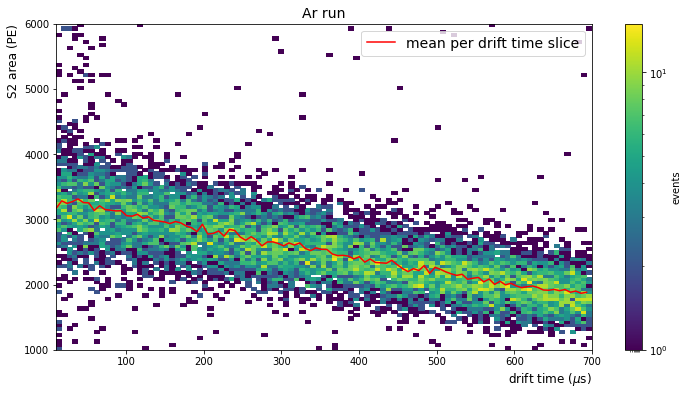

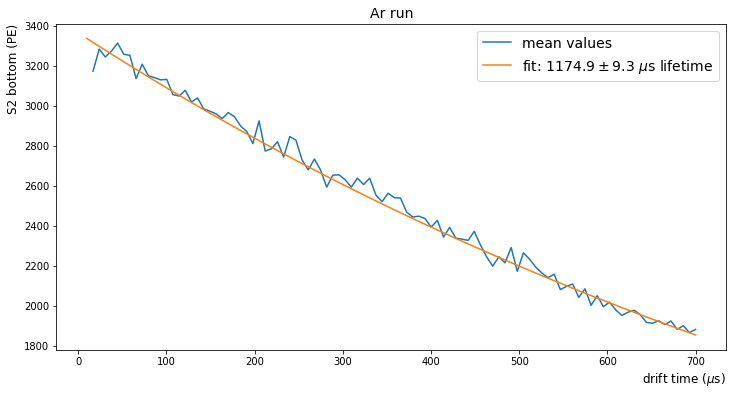

In [107]:
calculate_electron_lifetime(run_Ar,title='Ar run',area_cut=(1000,6000))